In [1]:
import torch
from basic_unet import UNet
from testnet import TestnetDataset
from torchvision import transforms
from pathlib import Path
import hdm
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import canny

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=1, out_channels=1)
state_dict = torch.load('models/2_testnet_0490.pth')
model.load_state_dict(state_dict)
model = model.to(device)
transform = transforms.Compose([
    transforms.Normalize([0.5, 0.5, 0.5, 0.5], [0.5, 0.5, 0.5, 0.5])
])
dataset = TestnetDataset(Path('testnet'), transform)

In [3]:
explainer = hdm.HausdorffDistanceMasks(240, 240)
explainer.generate_masks(circle_size=20, offset=5, normalize=False)

In [4]:
def plot(image, result, result_type, color_map):
    circle_map = result.circle_map(result_type, color_map=color_map)
    distances = result.distances(result_type)

    plt.imshow(circle_map)

    edges = canny(image.numpy(), sigma=0.01)
    plt.imshow(edges, alpha=0.5, cmap='gray_r')

    # fake image to show color bar
    zeros = np.zeros([240, 240])
    zeros[0][0] = distances.min()
    zeros[0][1] = distances.max()
    img = plt.imshow(zeros, alpha=0.0, cmap=color_map)
    bar = plt.colorbar(img)
    bar.set_alpha(1.0)

    bar.draw_all()
    plt.show()


def evaluate_plot(sample):
    segment = sample['segment']
    plt.imshow(segment, cmap='gray')
    plt.show()
    image = sample['input']
    result = explainer.explain(model, image, segment, device)
    print('Raw')
    plot(image[0], result, hdm.RAW, 'Blues')
    print('Worse when occluded')
    plot(image[0], result, hdm.WORSE_ONLY, 'Reds')
    print('Better when occluded')
    plot(image[0], result, hdm.BETTER_ONLY, 'Greens')

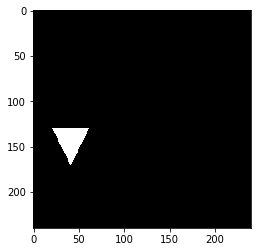

Raw


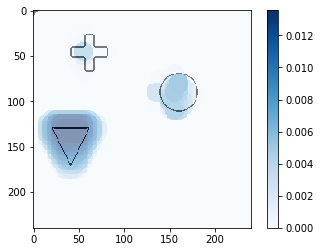

Worse when occluded


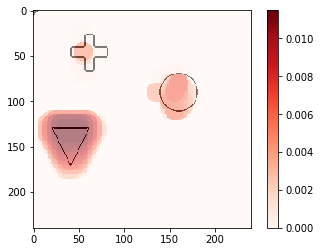

Better when occluded


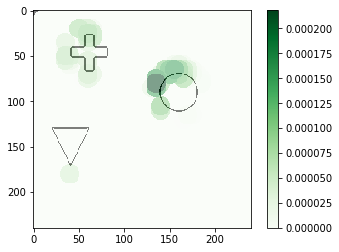

In [5]:
evaluate_plot(dataset.get_sample('0'))

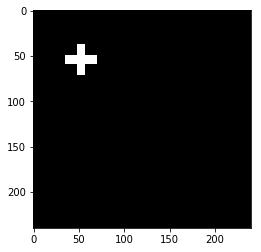

Raw


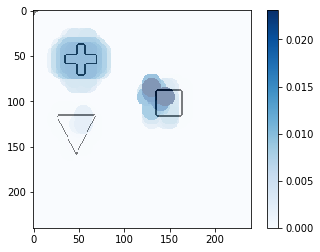

Worse when occluded


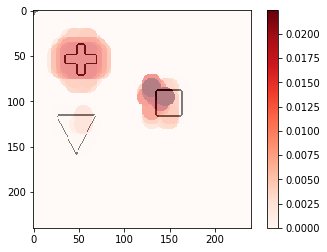

Better when occluded


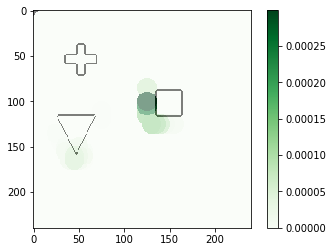

In [6]:
evaluate_plot(dataset.get_sample('1'))

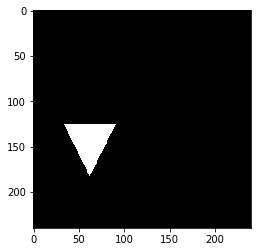

Raw


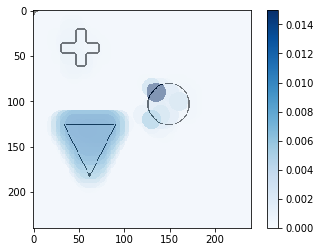

Worse when occluded


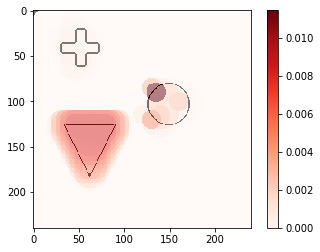

Better when occluded


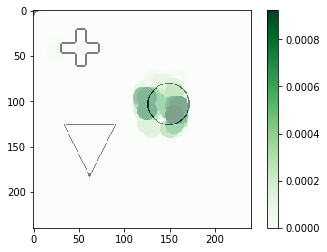

In [7]:
evaluate_plot(dataset.get_sample('2'))